In [1]:
import pandas as pd
import numpy as np



In [2]:
TOTAL = 'Monthly Mean Total Sunspot Number'
DIFF = 'Sunspot Diff'
df = pd.read_csv("../../datasets/Sunspots.csv")

In [3]:
df.drop(df.columns[0], axis=1, inplace=True)

In [4]:
df['Date'] = pd.to_datetime(df['Date']) #always format the date
df = df.sort_values(['Date'])


In [5]:
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


<Axes: >

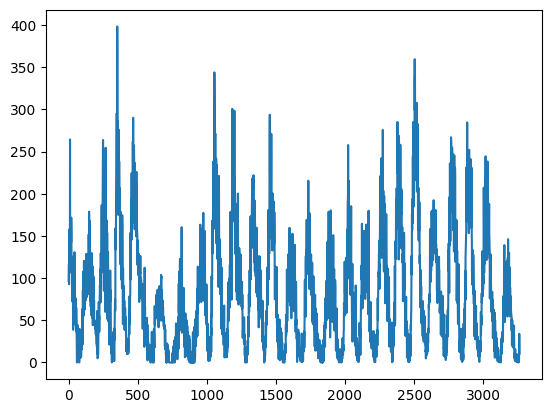

In [6]:
import matplotlib.pyplot as plt

df[TOTAL].plot()

In [7]:
# Defining a function to test stationarity
#SOURCE:https://github.com/tklouie/PyData_LA_2018/blob/master/PyData_LA_2018_Tutorial.ipynb

from statsmodels.tsa.stattools import adfuller


def show_moving_statistics(timeseries, window=12):

    # Determing rolling statistics
    rolmean = timeseries.rolling(window = window, center = False).mean()
    rolstd = timeseries.rolling(window = window, center = False).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color = 'blue',label = 'Original')
    mean = plt.plot(rolmean, color = 'red',label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for Sunspots')
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()


In [8]:
# https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [9]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

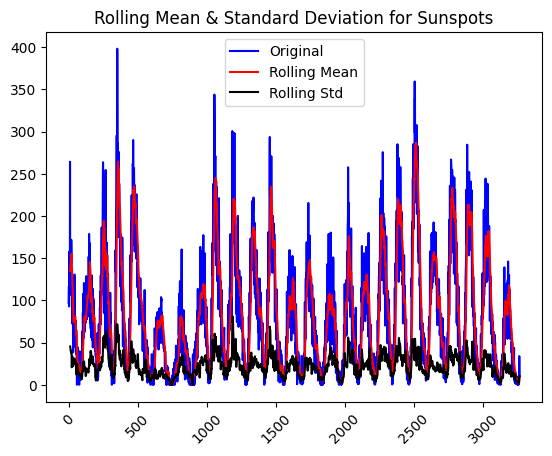

Results of Dickey-Fuller Test:
Test Statistic                -1.049705e+01
p-value                        1.108552e-18
#Lags Used                     2.800000e+01
Number of Observations Used    3.236000e+03
Critical Value (1%)           -3.432372e+00
Critical Value (5%)           -2.862434e+00
Critical Value (10%)          -2.567246e+00
dtype: float64
Results of KPSS Test:
Test Statistic            0.103805
p-value                   0.100000
Lags Used                36.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\piotr\Workspaces\timeseries-models\.venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [10]:
show_moving_statistics(df[TOTAL])
adf_test(df[TOTAL])
kpss_test(df[TOTAL])

## Z powyższego wynika, że dane są stacjonarne

In [11]:
df[DIFF] = df[TOTAL] - df[TOTAL].shift(
    1
)

<Axes: >

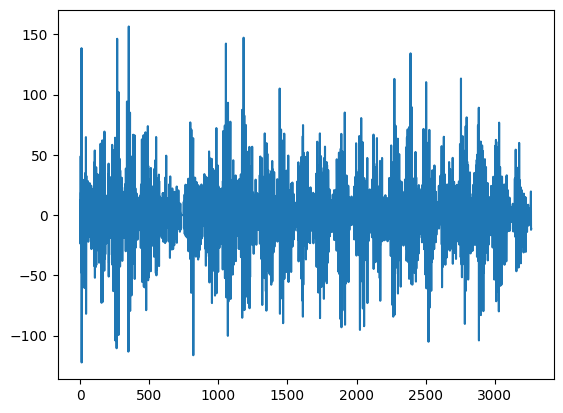

In [12]:
df[DIFF].plot()

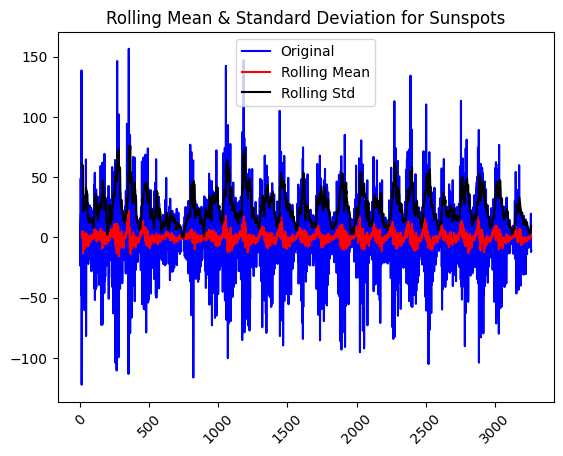

Results of Dickey-Fuller Test:
Test Statistic                -9.110773e+00
p-value                        3.404382e-15
#Lags Used                     2.800000e+01
Number of Observations Used    3.235000e+03
Critical Value (1%)           -3.432373e+00
Critical Value (5%)           -2.862434e+00
Critical Value (10%)          -2.567246e+00
dtype: float64
Results of KPSS Test:
Test Statistic            0.007336
p-value                   0.100000
Lags Used                36.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\piotr\Workspaces\timeseries-models\.venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [13]:
show_moving_statistics(df[DIFF].dropna())
adf_test(df[DIFF].dropna())
kpss_test(df[DIFF].dropna())

## Tu są jeszcze bardziej stacjonarne

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

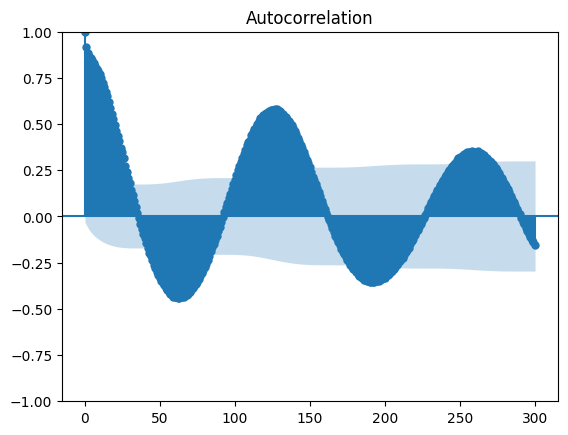

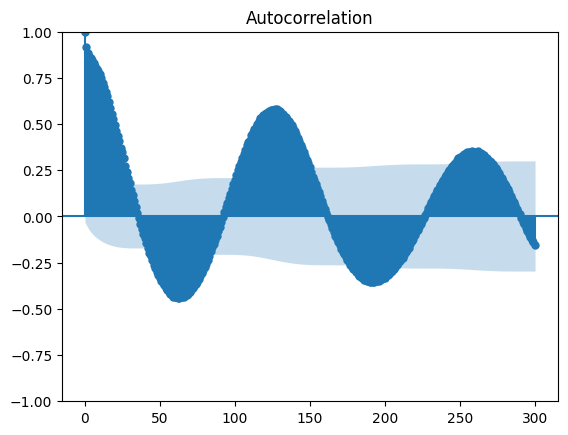

In [15]:
plot_acf(df[TOTAL], lags=300)

In [16]:
df[DIFF] = df[TOTAL] - df[TOTAL].shift(
    125
)


<Axes: >

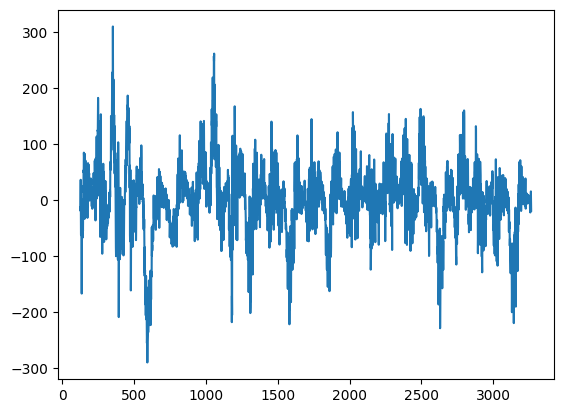

In [17]:
df[DIFF].plot()

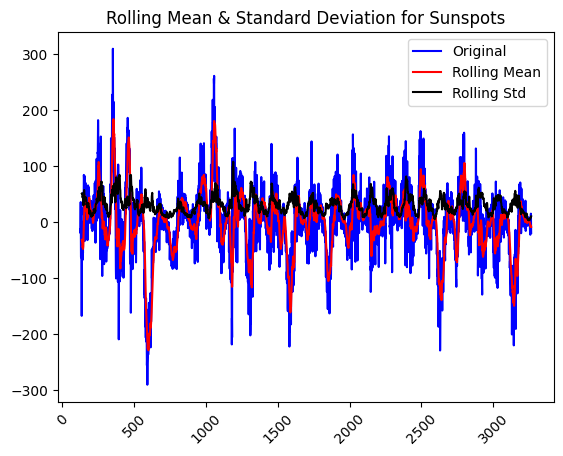

Results of Dickey-Fuller Test:
Test Statistic                -8.272534e+00
p-value                        4.750676e-13
#Lags Used                     2.800000e+01
Number of Observations Used    3.111000e+03
Critical Value (1%)           -3.432454e+00
Critical Value (5%)           -2.862469e+00
Critical Value (10%)          -2.567265e+00
dtype: float64
Results of KPSS Test:
Test Statistic            0.096406
p-value                   0.100000
Lags Used                31.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\piotr\Workspaces\timeseries-models\.venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [18]:
show_moving_statistics(df[DIFF].dropna())
adf_test(df[DIFF].dropna())
kpss_test(df[DIFF].dropna())

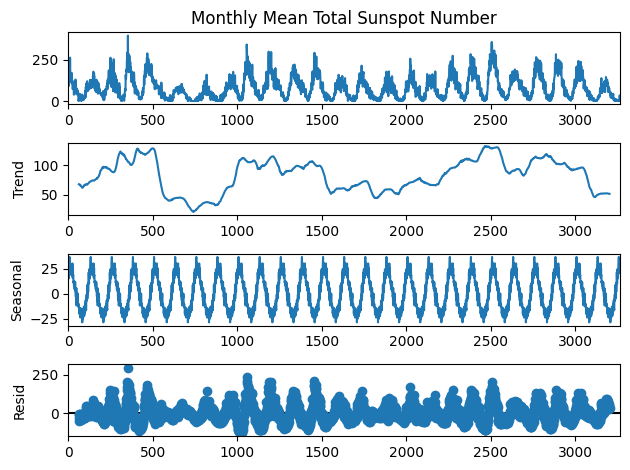

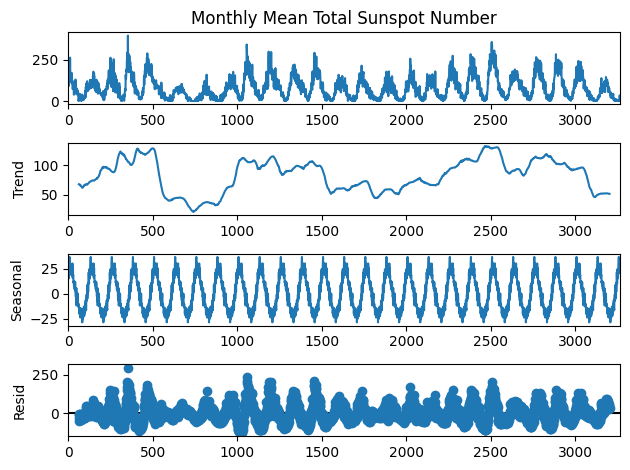

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df[TOTAL], model='additive', period=125)
result.plot()

In [150]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [165]:
n_steps_in, n_steps_out = 400, 1



In [204]:
import auto_esn.utils.dataset_loader as dl
import torch.nn
device = torch.device('cpu')

test_frac = 0.2
X = df[TOTAL]

test_obs =  int(np.round(test_frac*len(X)))
test_df = np.array(X)[-test_obs:]
train_df = np.array(X)[:-test_obs]

train_X, train_y, = split_sequence(train_df, n_steps_in, n_steps_out)
train_X = torch.from_numpy(train_X).to(device)
train_y = torch.from_numpy(train_y).to(device)


In [205]:
train_X.shape, train_y.shape

(torch.Size([2212, 400]), torch.Size([2212, 1]))

In [206]:
from auto_esn.esn.esn import DeepESN
from auto_esn.esn.reservoir.initialization import CompositeInitializer, WeightInitializer
from auto_esn.esn.reservoir.activation import Activation, Identity
i = CompositeInitializer()\
    .with_seed(23)\
    .sparse(density=0.1)\
    .spectral_noisy(spectral_radius=1.1, noise_magnitude=0.01)
    # .uniform()\
    # .regular_graph(4)\
    # .scale(0.9)\

w = WeightInitializer()
w.weight_hh_init = i


# esn = ESN(n_inputs = 24,
#           n_outputs = 1,
#           n_reservoir = 400,
#           sparsity=0.1,
#           random_state=23,
#           spectral_radius=1.1,
#           noise = 0.01,
#           silent=False)

esn = DeepESN(initializer = w, input_size=n_steps_in, hidden_size=400)
esn.fit(train_X, train_y)


In [207]:
predictions = np.array([])
window = train_X[-1].reshape((1,-1))

for i in range(test_obs):
    prediction = esn(window)
    window = train_X = torch.from_numpy(np.concatenate((window[:,1:],  prediction), axis=1)).to(device)
    predictions = np.append(predictions, prediction[0,0])

In [208]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_df[:50], predictions[:50])
mse

2216.668967719317

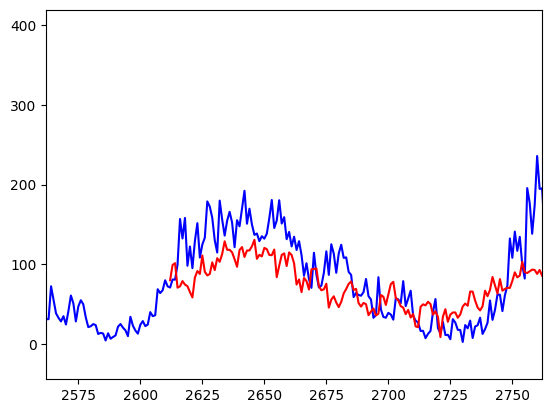

In [209]:
plt.plot(X, color = 'blue', label = 'Original')
plt.plot(range(len(X)-test_obs, len(X)), predictions, color = 'red',label = 'Rolling Mean')
plt.xlim((len(X)-test_obs-50, len(X)-test_obs+150))
plt.show()

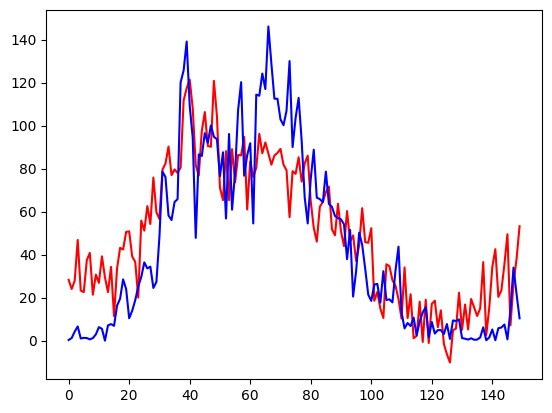

In [210]:
test_X, test_y, = split_sequence(test_df, n_steps_in, n_steps_out)
test_X = torch.from_numpy(test_X).to(device)
test_y = torch.from_numpy(test_y).to(device)
output = esn(test_X)
last = 150
plt.plot(range(last), output.view(-1).detach().numpy()[-last:], 'r')
plt.plot(range(last), test_y.view(-1).detach().numpy()[-last:], 'b')
plt.show()

In [184]:
X = df[TOTAL]

test_obs =  int(np.round(test_frac*len(X)))
test_df = np.array(X)[-test_obs:]
train_df = np.array(X)[:-test_obs]

train_X, train_y, = split_sequence(train_df, n_steps_in, n_steps_out)

In [185]:
# https://towardsdatascience.com/predicting-stock-prices-with-echo-state-networks-f910809d23d4
from pyESN import ESN

esn = ESN(n_inputs = n_steps_in,
          n_outputs = n_steps_out,
          n_reservoir = 400,
          sparsity=0.1,
          random_state=23,
          spectral_radius=1.1,
          noise = 0.01,
          silent=False)

esn.fit(train_X, train_y)



harvesting states...
fitting...
training error:
19.107793706420924


array([[68.93180077],
       [95.61004809],
       [29.86574035],
       ...,
       [70.22063372],
       [82.53510365],
       [70.63481198]])

In [186]:
print(train_X.shape, train_y.shape)

(2212, 400) (2212, 1)


In [187]:
predictions = np.array([])
window = train_X[-1].reshape((1,-1))

for i in range(test_obs):
    prediction = esn.predict(window)
#     esn.fit(window, prediction) To chyba tak powinno działać, a nie działa - psuje wyniki
    window = np.concatenate((window[:,1:],  prediction), axis=1)
    predictions = np.append(predictions, prediction[0,0])

In [188]:
train_X[-1]

array([  4.9,   5.3,   8.7,   4.7,   0.4,   8.5,   5. ,   1. ,   0.4,
         5.7,  12.9,   7.2,  18.8,  32.9,  11.2,  15.3,  13.9,   6.7,
         9.5,  14.5,  25.7,  31.1,  34.1,  38.5,  20.4,  45.4,  76.2,
        56.5,  50.2,  70.1,  88.7, 107. , 102.5, 104.7, 123.9, 128.4,
       124.8,  90.9, 116.7,  87.2, 145. , 126.7, 148.2, 192.3, 205.6,
       220.9, 214.1, 139.7, 182.2, 194.4, 217.1, 241.8, 229.5, 167.9,
       208.2, 123.9, 147.9, 164. , 198.6, 144.2, 168.4, 212.3, 162.6,
       275.6, 192.8, 149.3, 165.3, 203.6, 154.7, 133.9, 129. , 107.8,
       181.9, 197.3, 168.3, 162.6, 176.3, 187.7, 146.9, 113.7,  70.2,
        84.1,  99.1, 138.9, 101.1,  90.6, 139.8, 112.5, 175.9, 110.8,
        91.5,  97.4, 113.8,  76.1,  74.3,  77.5,  54.6,  49. ,  99.6,
       111.4, 100.1, 109.8,  77.2,  64. ,  56.2,  59.5,  87.9,  90.4,
       101.2,  41.8,  18.9,  29.6,  33.7,  28.7,  32. ,  51.3,  37.6,
        20.7,  48.1,  45.7,  43.5,  23.6,  12.7,  22. ,  32.3,  16.7,
        13. ,  17. ,

In [189]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_df[:50], predictions[:50])
mse

2526.0303712327527

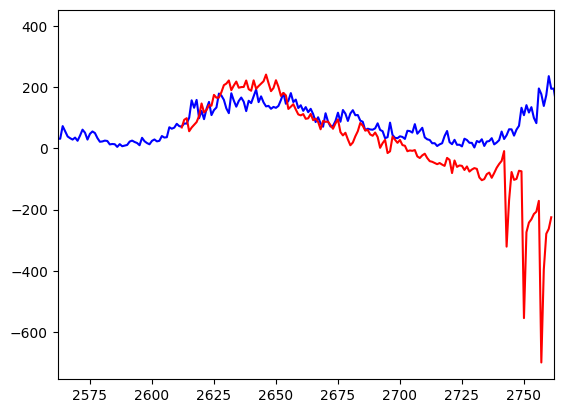

In [201]:
plt.plot(X, color = 'blue', label = 'Original')
plt.plot(range(len(X)-test_obs, len(X)-test_obs+150), predictions[:150], color = 'red',label = 'Rolling Mean')
plt.xlim((len(X)-test_obs-50, len(X)-test_obs+150))
plt.show()

1.7836167812347412
0.986384429822514


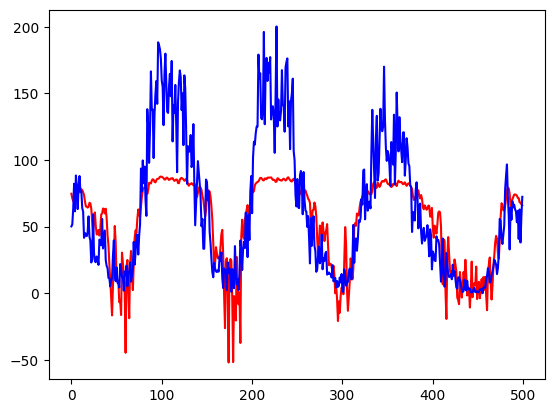

In [146]:
import time

import auto_esn.utils.dataset_loader as dl
from auto_esn.datasets.df import Sunspot
from auto_esn.esn.esn import DeepESN
from auto_esn.esn.reservoir.initialization import CompositeInitializer, WeightInitializer
from auto_esn.esn.reservoir.util import NRMSELoss
from matplotlib import pyplot as plt
norm = False
sunspot = dl.loader_explicit(Sunspot, test_size=600)
nrmse = NRMSELoss()
if norm:
    X, X_test, y, y_test, centr, spread = dl.norm_loader__(sunspot)
    y_test = spread * y_test + centr
else:
    X, X_test, y, y_test = sunspot()

i = CompositeInitializer()\
    .with_seed(12)\
    .uniform()\
    .regular_graph(4)\
    .spectral_normalize()\
    .scale(0.9)

w = WeightInitializer()
w.weight_hh_init = i

esn = DeepESN(initializer= w, hidden_size=500, num_layers=2)
start = time.time()
# esn.to_cuda()
esn.fit(X, y)

if norm:
    output = spread * esn(X_test) + centr
else:
    output = esn(X_test)
print(time.time()-start)
n = nrmse(output, y_test).item()
print(n)
last = 500
plt.plot(range(last), output.view(-1).detach().numpy()[-last:], 'r')
plt.plot(range(last), y_test.view(-1).detach().numpy()[-last:], 'b')
plt.show()

In [148]:
y.shape

torch.Size([2571, 1])

In [ ]:
X